In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manim
import scipy.ndimage as ndim
from numba import njit, prange
from tqdm import tqdm

In [3]:
L = 100
pi = 3.14159

t_step = L*L
steps = 1500
n_snaps = 30
snap = int(steps/n_snaps)
copies = 2

J = 1
X = 15

m = int(L/2)

H_init = 0
H_fin = 2.2
T_init = 0.01
T_fin = 2.2
delta_h = 0.1
delta_t = 0.1
H_size = 10
T_size = 10

#ising = np.ones((L,L)) #Initialised stable 
#For random initialisation: np.random.choice([1,-1], size = (L,L))

In [356]:
@njit 
def self_eng_per(spin, i, j, J_1, J_2, L): #Periodic boundaries
    s = spin[i,j]
    dE = 2*s*spin[i-1,j]/J_1
    dE += 2*s*spin[i,j-1]/J_1
    dE += 2*s*spin[(i+1)%L,j]/J_1
    dE += 2*s*spin[i,(j+1)%L]/J_1
    dE += 2*J_2*s/J_1
    return dE

In [357]:
@njit 
def metro(ising, L, t_step, J_1, J_2, mode ='g'): #Monte carlo update, L*L sweeps
    for _ in range(t_step):
        i = np.random.randint(0,L)
        j = np.random.randint(0,L)
        r = np.random.random()
        dE = self_eng_per(ising, i, j, J_1, J_2, L)
        if mode == 'g':
            if r < 1/(1+np.exp(dE)):
                ising[i,j] = -ising[i,j]
            else:
                ising[i,j] = ising[i,j]
        if mode == 'k':
            if dE <= 0 or r < np.exp(-dE):
                temp = ising[i][j]
                d = np.random.randint(0,2)
                r_2 = np.random.random()
                if d == 0:
                    z = int(np.sign(r_2-0.5))
                    ising[i][j] = ising[i][(j+z)%L]
                    ising[i][(j+z)%L] = temp
                if d == 1:
                    z = int(np.sign(r_2-0.5))
                    ising[i][j] = ising[(i+z)%L][j]
                    ising[(i+z)%L][j] = temp

In [358]:
@njit
def bubble_gen(y, ising, m): #Creates bubble of radius y
    R = int(y)+1
    for i in range(m-2*R, m+2*R):
        for j in range(m-2*R, m+2*R):
            if ((i-m)**2 + (j-m)**2) < y**2:
                ising[i,j] *= -1

In [359]:
@njit 
def radius_t(mag,L):
    R_t = float((1/np.sqrt(2*pi))*L*np.sqrt(1-mag))
    return R_t

In [360]:
@njit (parallel = True)
def para_sweep(L,J_1,J_2,X,copies,t_step,m,steps,snap):
    R = np.empty(copies)
    memory = np.empty(copies)
    t_sat = np.empty(copies)
    for k in prange(0, copies):
        ising = np.ones((L,L))
        bubble_gen(X, ising, m)
        for i in range (0, steps):
            metro(ising, L, t_step, J_1, J_2)
            mag = float(np.sum(ising)/(t_step))
            # '''
            if abs(mag+1) <= 0.001:
                t_sat[k] += i
                R[k] += radius_t(mag,L)
                memory[k] += mag
                # print(i)
                break 
            if abs(mag-1) <= 0.001:
                t_sat[k] += i
                R[k] += radius_t(mag,L)
                memory[k] += mag
                # print(i)
                break
            if i == steps-1:
                # t_sat[k] += i
                memory[k] += mag
                R[k] += radius_t(mag,L)
    return (np.sum(memory)/copies, np.sum(R)/copies, np.sum(t_sat)/copies)

In [361]:
H_list = np.linspace(H_init,-H_fin,num=H_size)
T_list = np.linspace(T_init,T_fin,num=T_size)

R_plt = np.empty((H_size, T_size))
M_plt = np.empty((H_size, T_size))
Time_plt = np.empty((H_size, T_size))

for i in tqdm(range(0,H_size), desc = "H sweep"):
    for j in range(0,T_size):
        fin_mag, fin_R, sat_time = para_sweep(L,T_list[j],H_list[i],X,copies,t_step,m,steps,snap)
        R_plt[i,j] = fin_R
        M_plt[i,j] = fin_mag
        Time_plt[i,j] = sat_time

H sweep: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


In [362]:
np.savez('Plot_temp11_data.npz',Mag=M_plt,Radius=R_plt,Sat_time=Time_plt,H_list=H_list,T_list=T_list,time=steps,copies=copies,R_0=X)

In [4]:
path = "Phase_plot_data/Plot_temp2_data.npz"
path_2 = "Phase_plot_data/Plot_temp2_data.npz"
data = np.load(path)
data_2 = np.load(path_2)
R_plt = data['Radius']
R_plt_2 = data_2['Radius']
M_plt = data['Mag']
M_plt_2 = data_2['Mag']
Time_plt = data['Sat_time']
H_list = data['H_list']
H_list_2 = data_2['H_list']
T_list = data['T_list']
X = data['R_0']
X_2 = data_2['R_0']
print(np.min(H_list_2), np.max(T_list), len(H_list), X, X_2)

-2.2 2.2 20 15 15


Notes:\
Plot 7 = no sat time, r0 = 10\
Plot 8 = no sat time, r0 = 20\
Plot 9 = no sat time, r0 = 6\
Plot 10 = r0 = 0\
Plot 11 = full r0 = 0 plot\
Plot 12 = no sat time, r0 = 30\
Plot 13 = r0 = 10, with sat time\
temp2 = r0 = 15, sat time\
temp3 = lower res of 2\
temp4 = same\
temp5 = same, no sat time\
temp6 = same\
temp9 = no cutoff time I think\


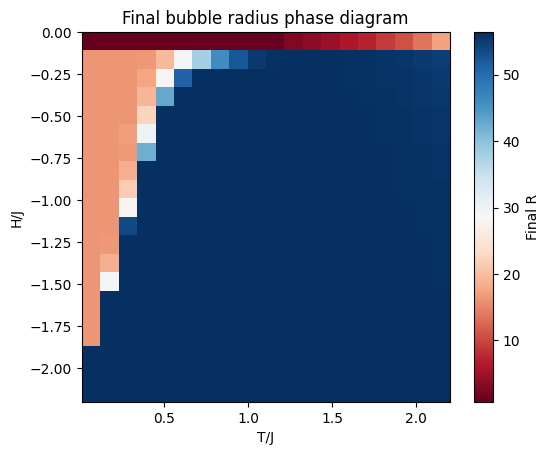

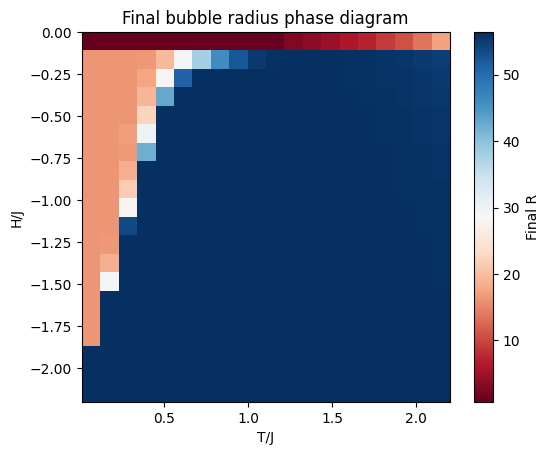

In [5]:
plt.figure()
plt.imshow(R_plt, interpolation = 'none', extent=[np.min(T_list),np.max(T_list),np.min(H_list),np.max(H_list)],origin='upper',cmap='RdBu')
plt.colorbar(label="Final R")
plt.xlabel("T/J")
plt.ylabel("H/J")
plt.title("Final bubble radius phase diagram")
plt.show()
plt.imshow(R_plt_2, interpolation = 'none', extent=[np.min(T_list),np.max(T_list),np.min(H_list_2),np.max(H_list_2)],origin='upper',cmap='RdBu')
plt.colorbar(label="Final R")
plt.xlabel("T/J")
plt.ylabel("H/J")
plt.title("Final bubble radius phase diagram")
plt.show()

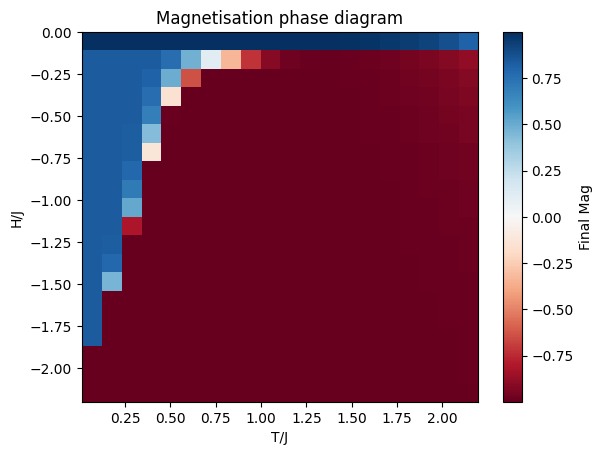

In [6]:
plt.imshow(M_plt,interpolation='none',extent=[np.min(T_list),np.max(T_list),np.min(H_list),np.max(H_list)],origin='upper',aspect='auto',cmap='RdBu')
plt.colorbar(label="Final Mag")
plt.xlabel("T/J")
plt.ylabel("H/J")
plt.title("Magnetisation phase diagram")
plt.show()

2.084736842105263 -2.0842105263157897


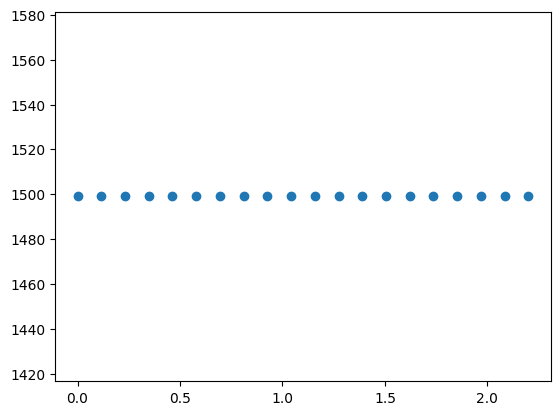

In [7]:
plt.scatter(-H_list, Time_plt[:,18])
print(T_list[18], H_list[18])
# print(M_plt[:,9])
# print(R_plt[:][8])
plt.show()

-2.644124977171813 4.447951651353703


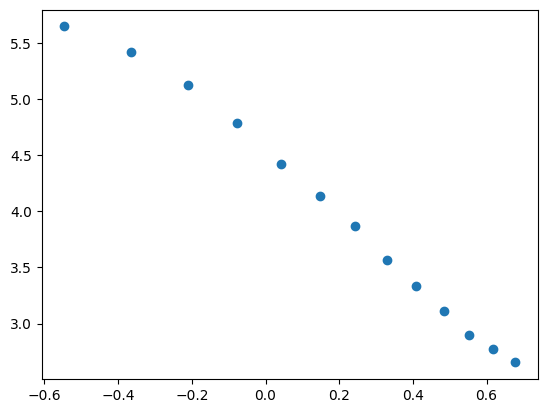

In [9]:
plt.scatter(np.log(-H_list[5:18]), np.log(Time_plt[5:18,8]))
a, b = np.polyfit(np.log(-H_list[5:18]), np.log(Time_plt[5:18,8]), 1)
print(a,b)
plt.show()